#Copy Number Variation (CNV) Analysis

This second part of the leukemia genomic analysis focuses on **Copy Number Variations (CNVs)** - genomic alterations where segments of DNA are duplicated (gains) or deleted (losses). You may find the first part here: https://colab.research.google.com/drive/1ksbh_7BFmqgmVLqyUCkTACh43j9TZDGs#scrollTo=jPoHhSborU10

CNVs play a major role in cancer biology. They can lead to oncogene amplification, tumor suppressor loss, or disruption of dosage-sensitive genes. Analyzing CNVs alongside point mutations gives us a more complete picture of the genomic landscape in leukemia.

This section follows a similar logic as the previous mutation analysis:
1. Data loading and cleaning
2. CNV classification
3. Gene-level frequency analysis
4. Visual summaries of gain/loss events


# Importing Libraries
For this project will be used:
- Pandas;
- Numpy;
- Matplotlib.




# Data Loading CNV dataset

The CNV data contains structural alterations that are not captured in the mutation dataset. By analyzing them independently, we can quantify how frequently genes are amplified or deleted in leukemia samples - providing an additional layer of insight into cancer-driving mechanisms.




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


###Connect to Google Drive and Set the Working Folder


In [ ]:
#@title Mount Google Drive and Set Project Folder

from google.colab import drive
import os
from IPython.display import display
import ipywidgets as widgets

# Mount Google Drive
drive.mount('/content/drive')

# Create a text input widget for folder name
folder_input = widgets.Text(
    value='Leukemia_Project/CNV',
    placeholder='Enter the folder name (e.g., Leukemia_Project/CNV)',
    description='Folder:',
    layout=widgets.Layout(width='60%')
)

# Display the input box
display(folder_input)

# Function to change directory based on user input
def change_directory(change):
    folder_name = change['new']
    path = f"/content/drive/MyDrive/{folder_name}"
    os.makedirs(path, exist_ok=True)
    os.chdir(path)
    print(f" Current directory: {os.getcwd()}")

# Activate listener to change directory
folder_input.observe(change_directory, names='value')


Mounted at /content/drive


Text(value='Leukemia_Project/CNV', description='Folder:', layout=Layout(width='60%'), placeholder='Enter the f…

In [ ]:
df_cnv = pd.read_csv("/content/drive/MyDrive/Leukemia_Project/CNV/TABLES/CNV_Summary_Leukemia.csv")

In [ ]:
#@title Data Cleaning

# Remove rows with missing gene names and duplicates
df_cnv = df_cnv.dropna(subset=['Gene'])
df_cnv = df_cnv.drop_duplicates()

# Standardize gene name format
df_cnv['Gene'] = df_cnv['Gene'].str.strip().str.upper()

# Identify numeric columns with potential missing values
# Remove 'Total CNV Events' as it's not in the initial DataFrame
numeric_cols = ['Gain', 'High-level Gain', 'Loss', 'High-level Loss']
missing_values = df_cnv[numeric_cols].isna().sum()
print("Missing values in numeric columns:\n", missing_values)

# Calculate 'Total CNV Events' after handling missing values in other columns
df_cnv['Total CNV Events'] = df_cnv[numeric_cols].sum(axis=1) # Creating the column here

# Identify genes with zero CNV activity
zero_cnv = df_cnv[df_cnv['Total CNV Events'] == 0]
print(f"Genes with Total CNV Events = 0: {len(zero_cnv)}")

# Preview dataset
print("CNV data shape after cleaning:", df_cnv.shape)
df_cnv.head()

Missing values in numeric columns:
 Gain               0
High-level Gain    0
Loss               0
High-level Loss    0
dtype: int64
Genes with Total CNV Events = 0: 0
CNV data shape after cleaning: (12926, 9)


,Gene,Gain,High-level Gain,Total Samples,Loss,High-level Loss,No Change,Net CNV,Total CNV Events
0,DSCAM,11,2,193,4,0,173,7,17
1,UGT2B17,8,2,193,0,0,0,8,10
2,ARL17B_ENST00000570618,7,2,193,0,0,0,7,9
3,HLA-DRB1,7,0,193,7,0,173,0,14
4,HLA-DRB5,7,0,193,7,0,173,0,14


#### Missing or incomplete values were handled systematically to ensure dataset integrity. Rows lacking gene identifiers were removed. All numeric columns related to CNV activity (e.g., Gain, Loss, High-level Gain, High-level Loss) were explicitly converted to numeric format using pd.to_numeric(errors='coerce'), and checked for missing values. No missing values were found. Additionally, genes with Total CNV Events = 0 were identified, and none were present in the dataset. This confirms that all genes in the final dataset exhibit some level of CNV activity, allowing for comprehensive downstream analysis without filtering artifacts.


#Data Processing - CNV Aggregation & Classification

To identify the most affected genes in terms of structural variation, we sum gains and losses per gene. Classifying the dominant CNV type helps distinguish genes primarily affected by amplifications versus deletions, which may reflect different biological mechanisms (e.g., oncogene amplification vs. tumor suppressor loss).


In [ ]:
#@title Load data using header from file
cnv_path = '/content/drive/MyDrive/Leukemia_Project/CNV/CNV Leukemia - CNV Leukemia.csv.csv'
df_cnv = pd.read_csv(cnv_path, header=0)
df_cnv.columns = df_cnv.columns.str.strip()  # Remove any trailing tabs or spaces

# Convert numeric columns
for col in ['Gain', 'High-level Gain', 'Total Samples', 'Loss', 'High-level Loss', 'No Change']:
    df_cnv[col] = pd.to_numeric(df_cnv[col], errors='coerce')

# Derive Net CNV
df_cnv['Net CNV'] = df_cnv['Gain'] - df_cnv['Loss']

# Save cleaned dataframe
save_to_tables(df_cnv, 'CNV_Summary_Leukemia.csv')

📄 Table saved at: /content/drive/MyDrive/Leukemia_Project/CNV/TABLES/CNV_Summary_Leukemia.csv


### In the table above we checked Derive Net CNV
 Net CNV (Copy Number Variation) is calculated as the difference between Gain and Loss. It reflects the net balance of copy number changes per gene: positive values indicate more amplifications, negative values indicate more deletions, and zero indicates a balanced alteration.
df_cnv['Net CNV'] = df_cnv['Gain'] - df_cnv['Loss']

In [ ]:
#@title Check for structural CNV types beyond gain/loss
print("Checking for structural CNV types...")

# List of terms representing other CNV types
structural_terms = ['insertion', 'inversion', 'translocation', 'duplication']

# Columns in the current dataset
available_columns = df_cnv.columns.tolist()

# Check if any structural CNV type appears in column names
found_structural = [col for col in available_columns if any(term in col.lower() for term in structural_terms)]

if found_structural:
    print("Structural CNV types detected in the dataset:")
    print(found_structural)
else:
    print("No insertion, inversion, translocation, or duplication columns found in this dataset.")


Checking for structural CNV types...
No insertion, inversion, translocation, or duplication columns found in this dataset.


In [ ]:
#@title Total CNV Events and Classify CNV Type

# Convert numeric columns in case they are still strings
df_cnv[['Gain', 'High-level Gain', 'Loss', 'High-level Loss']] = df_cnv[
    ['Gain', 'High-level Gain', 'Loss', 'High-level Loss']
].apply(pd.to_numeric, errors='coerce')

# Total number of CNV events per gene (including high-level gain and loss)
df_cnv['Total CNV Events'] = (
    df_cnv['Gain'] + df_cnv['High-level Gain'] +
    df_cnv['Loss'] + df_cnv['High-level Loss']
)

# Classify dominant CNV alteration type
def classify_cnv_detailed(row):
    total_gains = row['Gain'] + row['High-level Gain']
    total_losses = row['Loss'] + row['High-level Loss']

    if total_gains > total_losses:
        return 'Gain'
    elif total_losses > total_gains:
        return 'Loss'
    elif total_gains == total_losses and total_gains > 0:
        return 'Equal'
    else:
        return 'No Event'

# Apply classification
df_cnv['CNV Type'] = df_cnv.apply(classify_cnv_detailed, axis=1)

# Select top 10 most altered genes
top_cnv_genes = df_cnv.sort_values(by='Total CNV Events', ascending=False).head(10)
top_cnv_genes[['Gene', 'Gain', 'High-level Gain', 'Loss', 'High-level Loss', 'Total CNV Events']]


,Gene,Gain,High-level Gain,Loss,High-level Loss,Total CNV Events
1291,COX4I2,1.0,0.0,91.0,0.0,92.0
1292,DUSP15,1.0,0.0,89.0,0.0,90.0
1293,TTLL9,1.0,0.0,78.0,9.0,88.0
1295,PDRG1,1.0,0.0,59.0,11.0,71.0
6760,RALGAPA2,0.0,3.0,48.0,16.0,67.0
1294,PBX4,1.0,0.0,61.0,0.0,62.0
8775,PRKX,0.0,1.0,4.0,50.0,55.0
1296,MYLK2,1.0,0.0,53.0,0.0,54.0
1298,HM13,1.0,0.0,43.0,9.0,53.0
7442,LBP,0.0,1.0,50.0,0.0,51.0


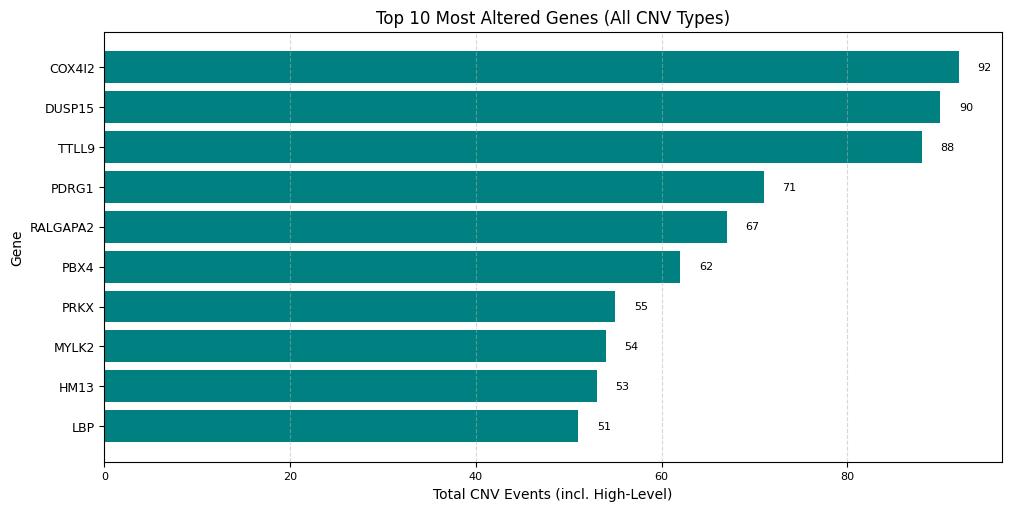

In [ ]:
#@title Top 10 Most Altered Genes

# Ensure TABLES/ directory exists and save CSV file

def save_to_tables(df, filename):
    os.makedirs('TABLES', exist_ok=True)
    full_path = os.path.join('TABLES', filename)
    df.to_csv(full_path, index=False)
    print(f" Table saved at: {os.path.abspath(full_path)}")

os.makedirs("PLOTS", exist_ok=True)

plt.figure(figsize=(10, 5), constrained_layout=True)
bars = plt.barh(top_cnv_genes['Gene'], top_cnv_genes['Total CNV Events'], color='teal')

plt.xlabel("Total CNV Events (incl. High-Level)", fontsize=10)
plt.ylabel("Gene", fontsize=10)
plt.title("Top 10 Most Altered Genes (All CNV Types)", fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=9)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 2, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center', ha='left', fontsize=8)

# Agora sim: salvar o gráfico
plt.savefig("PLOTS/refined_cnv_top_genes.tiff", format='tiff', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#@title Classify dominant CNV alteration type
def classify_cnv_detailed(row):
    total_gains = row['Gain'] + row['High-level Gain']
    total_losses = row['Loss'] + row['High-level Loss']

    if total_gains > total_losses:
        return 'Gain'
    elif total_losses > total_gains:
        return 'Loss'
    elif total_gains == total_losses and total_gains > 0:
        return 'Equal'
    else:
        return 'No Event'

# Apply classification
df_cnv['CNV Type'] = df_cnv.apply(classify_cnv_detailed, axis=1)


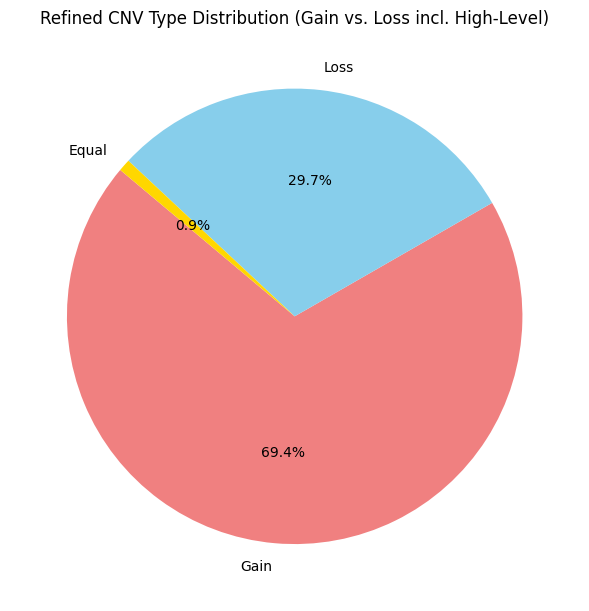

Pie chart saved at: /content/drive/MyDrive/Leukemia_Project/CNV/PLOTS/refined_cnv_type_distribution.tiff


In [ ]:
#@title CNV Type Distribution Pie Chart

# Count CNV Type categories
cnv_type_counts = df_cnv['CNV Type'].value_counts()

# Create PLOTS directory if it doesn't exist
os.makedirs("PLOTS", exist_ok=True)

# Pie chart
plt.figure(figsize=(6, 6), constrained_layout=True)
plt.pie(
    cnv_type_counts,
    labels=cnv_type_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['lightcoral', 'skyblue', 'gold', 'lightgrey']
)

plt.title("Refined CNV Type Distribution (Gain vs. Loss incl. High-Level)")
plt.savefig("PLOTS/refined_cnv_type_distribution.tiff", format='tiff', dpi=300, bbox_inches='tight')
plt.show()

print(f"Pie chart saved at: {os.path.abspath('PLOTS/refined_cnv_type_distribution.tiff')}")



### Mutation vs. CNV Comparison

This plot compares the frequency of mutations and CNVs across the top shared genes. It highlights genes affected by both point mutations and structural copy number alterations, suggesting they may play a central role in leukemogenesis.

This integrative view supports prioritization of targets for further biological or clinical investigation.


In [ ]:
#@title Total number of CNV events per gene (including high-level gain and loss)
df_cnv['Total CNV Events'] = (
    df_cnv['Gain'] + df_cnv['High-level Gain'] +
    df_cnv['Loss'] + df_cnv['High-level Loss']
)


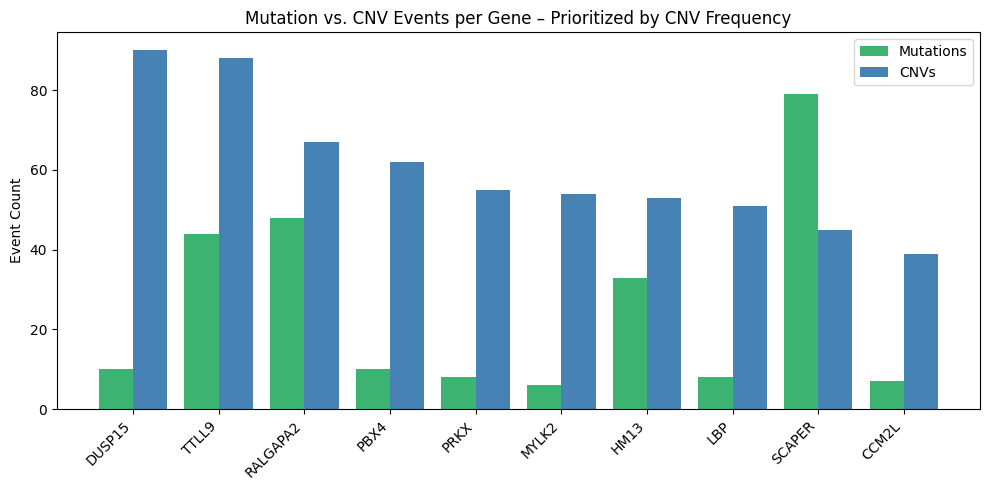

Grouped bar chart saved at: /content/drive/MyDrive/Leukemia_Project/CNV/PLOTS/mutation_vs_cnv_topCNV.tiff


In [ ]:
#@title Mutation vs. CNV Events per Gene – Top CNV Genes

# Seleciona os 10 genes com mais CNVs
top_cnv = merged_counts.sort_values(by=['Total CNV Events', 'Mutation Count'], ascending=False).head(10)

x = np.arange(len(top_cnv['Gene']))
width = 0.4

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, top_cnv['Mutation Count'], width, label='Mutations', color='mediumseagreen')
plt.bar(x + width/2, top_cnv['Total CNV Events'], width, label='CNVs', color='steelblue')

plt.xticks(x, top_cnv['Gene'], rotation=45, ha='right')
plt.ylabel("Event Count")
plt.title("Mutation vs. CNV Events per Gene – Prioritized by CNV Frequency")
plt.legend()
plt.tight_layout()
plt.savefig("PLOTS/mutation_vs_cnv_topCNV.tiff", format='tiff', dpi=300, bbox_inches='tight')
plt.show()
print(f"Grouped bar chart saved at: {os.path.abspath('PLOTS/mutation_vs_cnv_topCNV.tiff')}")

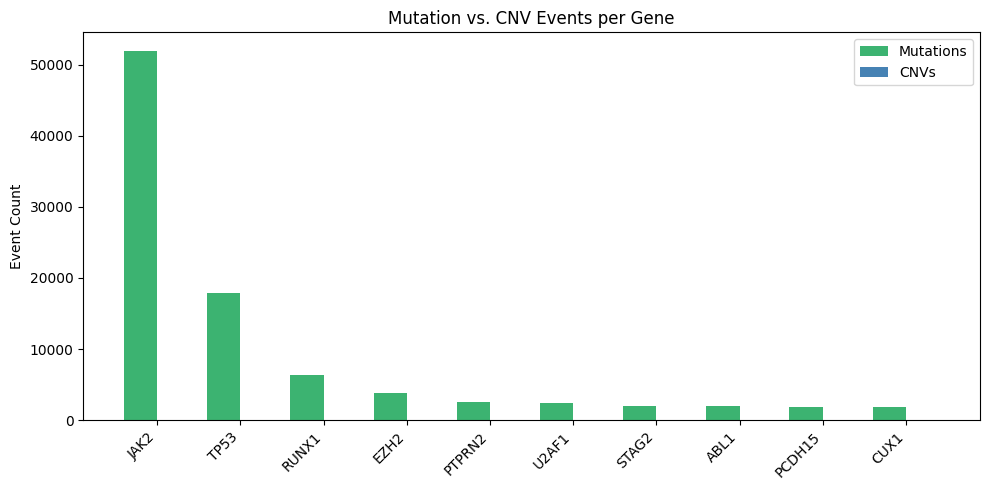

 Grouped bar chart saved at: /content/drive/MyDrive/Leukemia_Project/CNV/PLOTS/mutation_vs_cnv_comparison.tiff


In [ ]:
#@title  Mutation vs. CNV Events per Gene (Grouped Bar Chart)

# Load and prepare mutation data
mutation_path = "/content/drive/MyDrive/Leukemia_Project/CNV/Mutations Leukemia.csv"
df = pd.read_csv(mutation_path)
df = df[df['Gene Name'] != 'GENE NAME']  # remove extra header if needed

# Clean gene names by removing transcript IDs
mutation_gene_counts = df['Gene Name'].str.split('_').str[0].value_counts().reset_index()
mutation_gene_counts.columns = ['Gene', 'Mutation Count']

# Prepare CNV data
cnv_gene_counts = df_cnv[['Gene', 'Total CNV Events']]

# Merge the two datasets
merged_counts = pd.merge(mutation_gene_counts, cnv_gene_counts, on='Gene', how='inner')

# Select top genes based on both mutation and CNV frequency
top_merged = merged_counts.sort_values(
    by=['Mutation Count', 'Total CNV Events'],
    ascending=False
).head(10)

# Plot: Grouped bar chart
os.makedirs("PLOTS", exist_ok=True)

genes = top_merged['Gene']
mutation_vals = top_merged['Mutation Count']
cnv_vals = top_merged['Total CNV Events']
x = np.arange(len(genes))
width = 0.4

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, mutation_vals, width, label='Mutations', color='mediumseagreen')
plt.bar(x + width/2, cnv_vals, width, label='CNVs', color='steelblue')

plt.xticks(x, genes, rotation=45, ha='right')
plt.ylabel("Event Count")
plt.title("Mutation vs. CNV Events per Gene")
plt.legend()
plt.tight_layout()
plt.savefig("PLOTS/mutation_vs_cnv_comparison.tiff", format='tiff', dpi=300, bbox_inches='tight')
plt.show()

print(f" Grouped bar chart saved at: {os.path.abspath('PLOTS/mutation_vs_cnv_comparison.tiff')}")



# **Note on CNV Types**
While CNVs encompass various structural alterations - including deletions, duplications, insertions, inversions, and translocations - this analysis focuses on copy number gains and losses, as these are the primary events captured in the current dataset.


In [ ]:
#@title Pathway Enrichment Analysis (PEA) – Initial Setup

# Select top genes for enrichment analysis
# (you can change the method or use a predefined list)
top_pea_genes = df_cnv.sort_values(by='Total CNV Events', ascending=False)['Gene'].dropna().unique()[:200]

# Preview selected gene list
print("Top genes selected for PEA:")
print(top_pea_genes)

# Save to file if needed for external upload
os.makedirs("/content/drive/MyDrive/Leukemia_Project/CNV/PEA", exist_ok=True)
with open("/content/drive/MyDrive/Leukemia_Project/CNV/PEA/top_genes_for_enrichment.txt", "w") as f:
    for gene in top_pea_genes:
        f.write(f"{gene}\n")
print(" Gene list for enrichment saved at: PEA/top_genes_for_enrichment.txt")

KeyError: 'Total CNV Events'

In [ ]:
#@title Pathway Enrichment Analysis (PEA) – Initial Setup

# Assuming df_cnv has been correctly loaded and processed in previous cells, including the creation of 'Total CNV Events' column
# If not, make sure to execute those cells first.

# Recalculate 'Total CNV Events' in case it's missing
df_cnv['Total CNV Events'] = (
    df_cnv['Gain'] + df_cnv['High-level Gain'] +
    df_cnv['Loss'] + df_cnv['High-level Loss']
)

# Select top genes for enrichment analysis
# (you can change the method or use a predefined list)
top_pea_genes = df_cnv.sort_values(by='Total CNV Events', ascending=False)['Gene'].dropna().unique()[:200]

# Preview selected gene list
print("Top genes selected for PEA:")
print(top_pea_genes)

# Save to file if needed for external upload
os.makedirs("/content/drive/MyDrive/Leukemia_Project/CNV/PEA", exist_ok=True)
with open("/content/drive/MyDrive/Leukemia_Project/CNV/PEA/top_genes_for_enrichment.txt", "w") as f:
    for gene in top_pea_genes:
        f.write(f"{gene}\n")
print(" Gene list for enrichment saved at: PEA/top_genes_for_enrichment.txt")

Top genes selected for PEA:
['COX4I2' 'DUSP15' 'TTLL9' 'PDRG1' 'RALGAPA2' 'PBX4' 'PRKX' 'MYLK2' 'HM13'
 'LBP' 'LPAR2' 'SCAPER' 'CCM2L' 'ZNF682' 'ATP13A1'
 'SCAPER_ENST00000538941' 'SCAPER_ENST00000324767' 'DNAAF5' 'ZNF626'
 'LCE3C' 'ABCG1' 'LCE3B' 'ERG' 'ORAI3' 'MX1' 'RHD' 'DRC7' 'TRPM3' 'ZNF430'
 'TMPRSS3' 'TMEM231' 'VKORC1' 'KRI1' 'KATNB1' 'PRR14' 'DLD' 'FBN3'
 'TP53TG3B' 'DNAAF5_ENST00000403952' 'KEAP1' 'PSMC2' 'LUC7L2' 'UBE3C'
 'CRLF2' 'STARD3NL' 'RNF40' 'SH3BGR' 'COL20A1' 'MTG2' 'EIF4A1' 'PLAC1'
 'ILF3' 'PDAP1' 'DOCK6' 'PLPPR2' 'ITGB2' 'VPS26C' 'C2CD2' 'PDXK' 'ZNF93'
 'TTC3' 'EPOR' 'MAGEB2' 'TTC19' 'DERL1' 'SPEM2' 'COPS5' 'NSD3' 'INTS10'
 'RIPPLY3' 'NEIL2' 'PAFAH1B1' 'ICAM5' 'POMK' 'ATP6V1C1' 'PSMA2' 'PMS2'
 'PANX1' 'LIME1' 'ST6GALNAC3' 'UBASH3A' 'ICOSLG' 'CHCHD3' 'RABGEF1' 'FNTA'
 'GLOD4' 'KBTBD2' 'HUS1' 'SPDYE4' 'TMEM248' 'RAD21' 'RINT1' 'MYT1'
 'ZNF624' 'IMPAD1' 'EIF3G' 'ARCN1' 'IDI1' 'TMEM249' 'SOX8' 'PTK6' 'PRRG1'
 'TRAPPC10' 'ADAMTS1' 'ATXN7L1' 'SULF2' 'METTL9' 'ZDHHC11' 'WI

In [ ]:
#@title Remove transcript IDs (if any) and save final list to Drive

# Remove transcript suffix (e.g., SCAPER_ENST...) and keep only gene names
top_pea_genes_cleaned = [g.split('_')[0] for g in top_pea_genes]

# Remove duplicated gene names
top_pea_genes_unique = pd.Series(top_pea_genes_cleaned).drop_duplicates()

# Ensure target folder exists in Drive
os.makedirs("/content/drive/MyDrive/Leukemia_Project/CNV/PEA", exist_ok=True)

# Save cleaned and unique gene list
with open("/content/drive/MyDrive/Leukemia_Project/CNV/PEA/top_genes_unique.txt", "w") as f:
    for gene in top_pea_genes_unique:
        f.write(f"{gene}\n")

print("Final gene list saved at: /Leukemia_Project/CNV/PEA/top_genes_unique.txt")


Final gene list saved at: /Leukemia_Project/CNV/PEA/top_genes_unique.txt


## Final Remarks

This exploratory analysis integrated point mutation data and copy number variation (CNV) profiles from leukemia samples to identify genes affected by multiple types of genomic alterations.

Key findings include:
- Two complementary visualizations were produced: one highlighting genes with the highest number of CNV events, and another focusing on genes with the highest mutation counts (from the original mutation file).
- The dataset included only **copy number gains and losses**, including **high-level alterations**.  
  No insertion, inversion, translocation, or duplication-specific columns were found.
- Data cleaning ensured there were no missing or zero values in CNV features; all genes retained in the final dataset had at least one CNV event.
- Gene names were standardized, and duplicates removed prior to merging CNV and mutation data.

By combining CNV and mutation profiles, this analysis enabled a broader view of recurrently altered genes in leukemia. The merged visualization supports prioritization of genes that may be relevant for downstream pathway enrichment or functional investigation.

Note: To maintain clarity and separation of analyses, the functional enrichment (PEA/GO) will be performed in a dedicated notebook.

Future directions may include:
- CNV-type stratified visualization
- Clinical correlation (if metadata becomes available)

